# Wasserstein GAN with Gradient Penalty (WGAN-GP)

In [13]:
import torch
import torch.nn as nn
import random
import numpy as np
import pandas as pd
from scipy.special import lambertw
from torch.autograd import grad
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0) 

## Training Initializations

In [14]:
num_epochs = 5000
z_dim = 25
lr = 0.00002
beta_1 = 0.5
beta_2 = 0.999
c_lambda =10
crit_repeats = 3

batch_size = 1024
ts_dim  = 100
device = 'cpu'

591


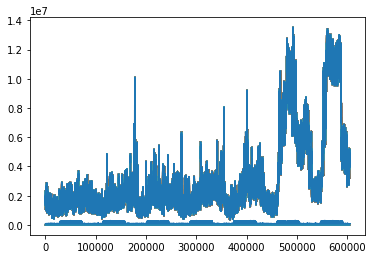

In [15]:
class TimeSeriesData(Dataset):
    def __init__(self, csv_file, csv_file_simulated, column, column_simulated, sampling_window, transform):
        self.file = pd.read_csv(csv_file)
        self.target = column
        self.data = self.file[self.target]
        self.scaler_1 = StandardScaler()
        self.scaler_2 = StandardScaler()
        self.preprocessed_data = None
        if transform:
            self.preprocessed_data = self.pre_processing(self.data, self.scaler_1, self.scaler_2)
            x_train, y_train = self.prepare_data(self.data, self.preprocessed_data)
            x_train, y_train = self.get_sequences(x_train, ts_dim), self.get_sequences(y_train, ts_dim)
        
        self.x_train = x_train 
        self.y_train = y_train

        self.simulated_data = pd.read_csv(csv_file_simulated)[column_simulated].values 
        plt.plot(self.simulated_data)
        plt.plot(self.x_train)
        plt.plot(self.y_train)
    
    def prepare_data(sellf, data, preprocessed_data):
        data = data.to_numpy()
        train_X = preprocessed_data
        train_Y = data
        return train_X, train_Y
    
    
    def pre_processing(self, data, scaler_1, scaler_2):
        delta=0.7
        constant=0.0
        data += constant
        log_returns = np.log(data/data.shift(1)).fillna(0).to_numpy()
        log_returns = np.reshape(log_returns, (log_returns.shape[0], 1))
        log_returns = scaler_1.fit_transform(log_returns)
        log_returns = np.squeeze(log_returns)
        
        log_returns_w = (np.sign(log_returns) * np.sqrt(lambertw(delta*log_returns**2)/delta)).real
        log_returns_w = log_returns_w.reshape(-1, 1)
        log_returns_w = scaler_2.fit_transform(log_returns_w)
        log_returns_w = np.squeeze(log_returns_w)

        return log_returns_w
    
    def get_sequences(self, data, window_length):
        sequences = []
        for i in range(len(data)):
            if i + window_length > len(data) - 1:
                break 
            sequences.append(data[i: i + window_length])
        return np.array(sequences)


    def __len__(self):
        return len(self.x_train)
    
    def __getitem__(self, index):
        data_point = self.x_train[index]
        samples = np.expand_dims(data_point, axis=0)
        samples = torch.from_numpy(samples)
        start = self.y_train[index]
        return samples, start

data_path = '/content/Cell_0_Slice_0_UE_0.csv'
simulated_path = '/content/UE1_Slice1.csv'
column = 'DataVolume_bits'
simulated_column = 'UE'

dataset = TimeSeriesData(csv_file = data_path,  csv_file_simulated = simulated_path, column = column, column_simulated = simulated_column,sampling_window = ts_dim, transform = True)
train_loader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = False)
print(len(train_loader))

(60, 604800)
(604800,)


array([6., 3., 3., ..., 3., 0., 0.])

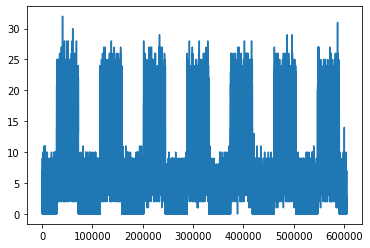

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from random import randint



def poission_generator(poissLambda, nDay):
    #traffic generator
    # Poisson rate for active user. (mbps), # number of days
    # number of cells
    nCell = 2
    # number of slice per cell
    nSlicePerCell = 3

    # number of UEs per slice
    nUePerSlice = 10

    # sampling rate uint second
    samplingRate = 1
    # duration: one day
    oneDayDuration = 24*60*60

    # enable randomized start and end time, users will not start and end at the same time. e.g., start time = ueActiveStart + rand(-3 hours, 3 hours)
    randActiveStartEndTime = False

    # UE active time start: 8 AM
    ueActiveStart = 8*60*60

    #UE active time stop: 10PM
    ueActiveStop = 20*60*60



    # deactive rate factor: when user is deactive, its rate equals poissLabda * deactiveFactor
    deactiveRateFactor = 0.2 #make  sure the poissLambda * deactiveFactor is much greater than 1!!!!!!!!!!!!!!!!

    nSamples = math.floor(oneDayDuration/samplingRate)

    ueActiveStartSampled = math.floor(ueActiveStart/samplingRate)
    ueActiveStopSampled = math.floor(ueActiveStop/samplingRate)

    #  generate rate for day one
    nFileAppend = np.zeros((nCell*nSlicePerCell*nUePerSlice, nSamples))
    # rate for deactive time in the morning
    nFileAppend[:, 0:ueActiveStartSampled] = np.random.poisson(deactiveRateFactor*poissLambda, [nCell*nSlicePerCell*nUePerSlice, ueActiveStartSampled])
    # rate for active time
    nFileAppend[:, ueActiveStartSampled:ueActiveStopSampled] = np.random.poisson(poissLambda, [nCell*nSlicePerCell*nUePerSlice, ueActiveStopSampled-ueActiveStartSampled])
    # rate for deactive time at night
    nFileAppend[:, ueActiveStopSampled::] = np.random.poisson(deactiveRateFactor*poissLambda, [nCell*nSlicePerCell*nUePerSlice, nSamples-ueActiveStopSampled])

    #rate for active time

    # append more data if simulate more than one day.
    for dayInd in range (1, nDay):

        nFile = np.zeros((nCell*nSlicePerCell*nUePerSlice, nSamples))
        # rate for deactive time in the morning
        nFile[:, 0:ueActiveStartSampled] = np.random.poisson(deactiveRateFactor*poissLambda, [nCell*nSlicePerCell*nUePerSlice, ueActiveStartSampled])
        # rate for active time
        nFile[:, ueActiveStartSampled:ueActiveStopSampled] = np.random.poisson(poissLambda, [nCell*nSlicePerCell*nUePerSlice, ueActiveStopSampled-ueActiveStartSampled])
        # rate for deactive time at night
        nFile[:, ueActiveStopSampled::] = np.random.poisson(deactiveRateFactor*poissLambda, [nCell*nSlicePerCell*nUePerSlice, nSamples-ueActiveStopSampled])
        nFileAppend = np.append(nFileAppend, nFile, axis=1)

    # time axis for plot
    timeIndex = np.linspace(0,24*nDay,nSamples*nDay)
    print(nFileAppend.shape)

    # generate name label to save in a svc file
    name = []
    loopInd = 0
    for cellInd in range (0, nCell):
        for sliceInd in range (0, nSlicePerCell):
            for userInd in range (0, nUePerSlice):
                name.append('Cell-'+str(cellInd)+'-Slice-'+str(sliceInd)+'-User-'+str(userInd))
                if randActiveStartEndTime:
                    nFileAppend[loopInd, :] = np.roll(nFileAppend[loopInd, :], randint(-3*60*60, 3*60*60))
                loopInd = loopInd + 1
    df = pd.DataFrame(np.transpose(nFileAppend),  columns=name)['Cell-0-Slice-0-User-0']
    data = np.array(df.values)
    print(data.shape)
    plt.plot(data)
    return np.array(df.values)

days = 7
lamb = 12
poission_generator(lamb, days)

### Generator and Noise

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, ts_dim, hidden_dim = 256, num_layers=2):
        super(Generator, self).__init__()
        self.ts_dim = ts_dim
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(z_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, ts_dim)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01, inplace=False)

    def forward(self, noise):
        out, _ = self.lstm(noise)
        out = self.linear(out.view(noise.size(0) * noise.size(1), self.hidden_dim))
        out = out.view(noise.size(0), noise.size(1), self.ts_dim)
        out = self.leaky_relu(out)
        return out

### Critic

In [ ]:
class Critic(nn.Module):
    def __init__(self, ts_dim, hidden_dim=256, num_layers=2):
        super(Critic, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(ts_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out.view(x.size(0) * x.size(1), self.hidden_dim))
        out = out.view(x.size(0), x.size(1), 1)
        return out

### Initializing the Models and Optimizers

In [ ]:
critic = Critic(ts_dim).to(device)
crit_optim = torch.optim.Adam(critic.parameters(), lr=lr, betas=(beta_1, beta_2))
generator = Generator(z_dim, ts_dim).to(device)
gen_optim = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta_1, beta_2))

### Training

In [ ]:
critic_losses = []
generator_losses = []
w_distance = []

num_epochs = 1

for epoch in range(num_epochs):
    for batch_index, item in tqdm(enumerate(train_loader)):
        if batch_index!=len(train_loader)-1:
            series, start_dates = item[0], item[1]
            crit_optim.zero_grad()
            for _ in range(crit_repeats):
                noise = torch.randn(batch_size, 1, z_dim).to(device)
                fake_series = generator(noise)
                prob_fake = critic(fake_series.detach())

                series = series.to(device)
                prob_real = critic(series.float())

                series, fake_series = series.float(), fake_series.float()
                epsilon = torch.rand(series.size(0), 1, 1).to(device)
                x_hat = (epsilon*series + (1 - epsilon)*fake_series).requires_grad_(True)
                x_hat_prob = critic(x_hat)
                x_hat_grad = torch.ones(x_hat_prob.size()).to(device)

                gradients = grad(outputs=x_hat_prob, inputs=x_hat, grad_outputs=x_hat_grad, create_graph=True, retain_graph=True, only_inputs=True)[0]
                gradients = gradients.view(gradients.size(0), -1)
                gp = torch.sqrt(torch.sum(gradients** 2, dim=1) + 1e-10)
                gp = torch.mean((gp-1)**2)
                wasserstein_distance = torch.mean(prob_real) - torch.mean(prob_fake) 
                penalty = c_lambda*gp
                crit_loss = -wasserstein_distance + penalty
                crit_loss.backward()
                crit_optim.step()

            gen_optim.zero_grad()
            fake_series = generator(noise)
            prob_fake = critic(fake_series)

            generator_loss = -1.* torch.mean(prob_fake)
            generator_loss.backward()
            gen_optim.step()


591it [06:29,  1.52it/s]


### Plotting Real Data

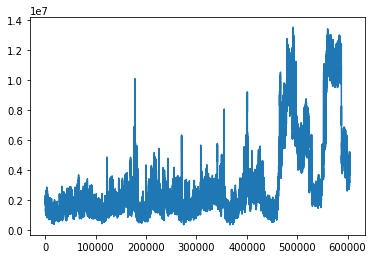

In [ ]:
plt.plot(dataset.data)

## Processing and generating whole synthetic data

In [ ]:
fake = []
delta=0.7
start_array = []

for idx in range(0, dataset.x_train.shape[0], ts_dim):
    end_ix = idx + ts_dim
    if end_ix > len(dataset.x_train)-1:
        break
    start = dataset.y_train[idx, 0]
    start_array.append(start)
    noise = torch.randn(1, 1, z_dim).to(device)
    with torch.no_grad():
        fake_series = generator(noise)
    
    print(fake_series.shape)

    assert fake_series.shape[2] == ts_dim, "Fake Series should be of the same size as ts_dim {}".format(ts_dim)

    fake_series = np.squeeze(fake_series.cpu().data.numpy()).reshape(-1, 1)
    fake_series = dataset.scaler_2.inverse_transform(fake_series)
    fake_series = fake_series * np.exp(0.5 * delta * fake_series **2)
    fake_series = dataset.scaler_1.inverse_transform(fake_series)
    fake_series = np.exp(fake_series)

    post_fake_series = np.empty((fake_series.shape[0], ))

    post_fake_series[0] = start
    for i in range(1, fake_series.shape[0]):
        post_fake_series[i] = post_fake_series[i-1]*fake_series[i]
    
    assert post_fake_series.shape[0] == ts_dim, "Post Fake Series should be of the same size as ts_dim {}".format(ts_dim)
    fake += np.array(post_fake_series).tolist()

torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])
torch.Size([1, 1

KeyboardInterrupt: ignored

In [ ]:
import copy
hold = copy.deepcopy(fake)

In [ ]:
print(len(hold))

604300


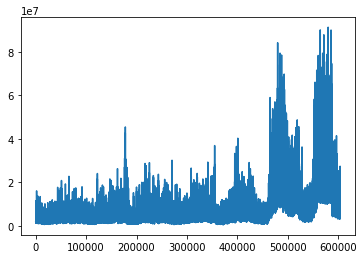

In [ ]:
plt.plot(hold)

## Trying some forecasting

In [ ]:
fake = copy.deepcopy(hold)
delta=0.7
start_array = []

for idx in range(0, 100000, ts_dim):
    end_ix = idx + ts_dim
    if end_ix > 100000:
        break
    start = fake[-1]
    start_array.append(start)
    noise = torch.randn(1, 1, z_dim).to(device)
    with torch.no_grad():
        fake_series = generator(noise)
    assert fake_series.shape[2] == ts_dim, "Fake Series should be of the same size as ts_dim {}".format(ts_dim)

    fake_series = np.squeeze(fake_series.cpu().data.numpy()).reshape(-1, 1)
    fake_series = dataset.scaler_2.inverse_transform(fake_series)
    fake_series = fake_series * np.exp(0.5 * delta * fake_series **2)
    fake_series = dataset.scaler_1.inverse_transform(fake_series)
    fake_series = np.exp(fake_series)

    post_fake_series = np.empty((fake_series.shape[0], ))

    post_fake_series[0] = start
    for i in range(1, fake_series.shape[0]):
        post_fake_series[i] = post_fake_series[i-1]*fake_series[i]
    
    assert post_fake_series.shape[0] == ts_dim, "Post Fake Series should be of the same size as ts_dim {}".format(ts_dim)
    fake += np.array(post_fake_series).tolist()


In [ ]:
len(dataset.data)

604500

In [ ]:
len(fake)

704300

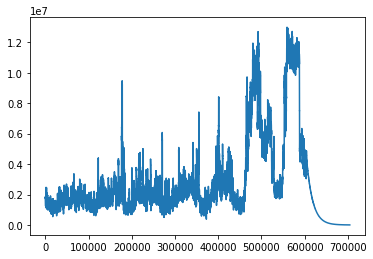

In [ ]:
plt.plot(fake)